In [1]:
import sys
sys.path.append('..')
import itertools, copy
import json
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lib import *

In [17]:
counter = count_kmers_proteome(human, 9)

In [18]:
df = counter_to_df(counter, norm=False)

In [6]:
seqmat = np.random.choice(df['seq'], p=df['count']/np.sum(df['count']), size=1000)
seqmat = np.array([list(seq) for seq in seqmat])
seqmat

array([['R', 'Q', 'N', ..., 'V', 'R', 'I'],
       ['V', 'I', 'L', ..., 'W', 'P', 'G'],
       ['H', 'Y', 'I', ..., 'Y', 'E', 'A'],
       ...,
       ['A', 'L', 'A', ..., 'E', 'S', 'H'],
       ['K', 'P', 'C', ..., 'P', 'V', 'G'],
       ['G', 'S', 'Y', ..., 'C', 'R', 'Y']], dtype='<U1')

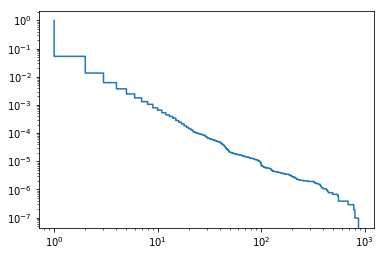

In [7]:
plot_sorted(df['count'])

In [8]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [9]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
df0 = df0.set_index('seq')
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [11]:
with open('../../data/triplet-human.json', 'r') as f:
    tripletparams = json.load(f)

In [12]:
print(10**loglikelihood_independent('ACL', **tripletparams))
print(10**loglikelihood_mc('ACL', **tripletparams))
print(10**loglikelihood_triplet('ACL', **tripletparams))

0.0001606189778362446
0.00013991001867381722
0.00014523024562271262


In [13]:
df1 = counter_to_df(counters[1])
df1 = df1[~df1['seq'].str.contains('U|B|X|Z')]
df1 = df1.set_index('seq')

In [14]:
dfgap1 = counter_to_df(count_kmers_proteome(human, 2, gap=1))
dfgap1 = dfgap1[~dfgap1['seq'].str.contains('U|B|X|Z')]
dfgap1 = dfgap1.set_index('seq')

In [15]:
dfgap2 = counter_to_df(count_kmers_proteome(human, 2, gap=2))
dfgap2 = dfgap2[~dfgap2['seq'].str.contains('U|B|X|Z')]
dfgap2 = dfgap2.set_index('seq')

In [16]:
def fit_ising(f1, f2s, niter=1, nmcmc=1e6, epsilon=0.1, Jk=None):
    h = np.log(f1['freq']).to_dict()
    aas_arr = np.array(list(aminoacids))
    if Jk is None:
        J0 = np.zeros((len(aminoacids), len(aminoacids)))
        J0 = pd.DataFrame(np.asarray(J0), index=list(aminoacids), columns=list(aminoacids)).to_dict()
        Jk = [J0]
        for gap in range(1, len(f2s)):
            Jk.append(copy.deepcopy(J0))
    for i in range(niter):
        jump = lambda x: ''.join(np.random.choice(aas_arr, size=6))
        x0 = jump(None)
        samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, nmcmc)
        for gap in range(len(f2s)):
            m = f2s[gap].merge(counter_to_df(count_kmers_iterable(samples, 2, gap=gap)), left_index=True, right_on='seq')
            m['logfold'] = np.log(m['freq_x']/m['freq_y'])
            print(i, gap, np.mean(np.abs(m['logfold'])))
            for idx, row in m.iterrows():
                logfold = row['logfold']
                aa1 = row['seq'][0]
                aa2 = row['seq'][1]
                Jk[gap][aa1][aa2] += logfold * epsilon
    return h, Jk

In [17]:
h, Jk = fit_ising(df0, [df1, dfgap1, dfgap2], nmcmc=1e6, niter=30, epsilon=0.2)

0 0 0.10429793783782065
0 1 0.08410809764518978
0 2 0.08640611559645833
1 0 0.08334721721473977
1 1 0.06821252847365958
1 2 0.07015722703756161
2 0 0.06801603253975291
2 1 0.05485272450306211
2 2 0.0557711151626902
3 0 0.055430027096046525
3 1 0.046862037841848406
3 2 0.04833755990788072
4 0 0.04455366256706822
4 1 0.03659363896268697
4 2 0.03835092335093573
5 0 0.0380505351547478
5 1 0.032195309078550595
5 2 0.035581757415785495
6 0 0.03135064197398842
6 1 0.027578766425860768
6 2 0.029817325236896775
7 0 0.027376523177706936
7 1 0.025338622854562162
7 2 0.02923585708608063
8 0 0.024193274913865616
8 1 0.024379546604133374
8 2 0.02697237890977554
9 0 0.02349992243342285
9 1 0.022610362130259434
9 2 0.024479491163196143
10 0 0.021832729999775195
10 1 0.021189351637803625
10 2 0.023649389091783445
11 0 0.02090412630646841
11 1 0.021475172768985917
11 2 0.024303431706697357
12 0 0.01969426903255963
12 1 0.02025020117884389
12 2 0.023270418570657116
13 0 0.018761020140167742
13 1 0.021320

In [18]:
jump = lambda x: ''.join(np.random.choice(list(aminoacids), size=8))
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, 1e6)

0.012357979324108842

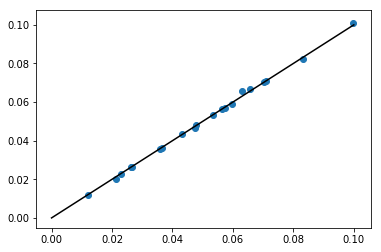

In [19]:
dfm0 = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])
dfm0['logfold'] = np.log(dfm0['freq_x']/dfm0['freq_y'])
np.abs(dfm0['logfold']).mean()

0.023649946144331278

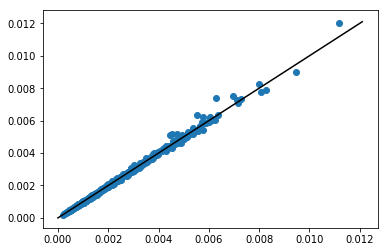

In [20]:
dfm1 = df1.merge(counter_to_df(count_kmers_iterable(samples, 2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.02488763053904738

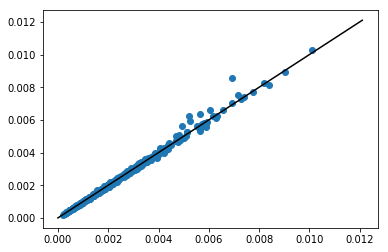

In [21]:
dfmgap1 = dfgap1.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

0.026734172676644352

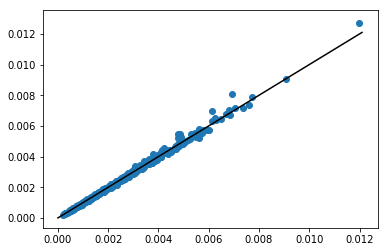

In [22]:
dfmgap2 = dfgap2.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap2['freq_x'], dfmgap2['freq_y'])
dfmgap2['logfold'] = np.log(dfmgap2['freq_x']/dfmgap2['freq_y'])
np.abs(dfmgap2['logfold']).mean()

In [23]:
dfJk = [pd.DataFrame.from_dict(J) for J in Jk]

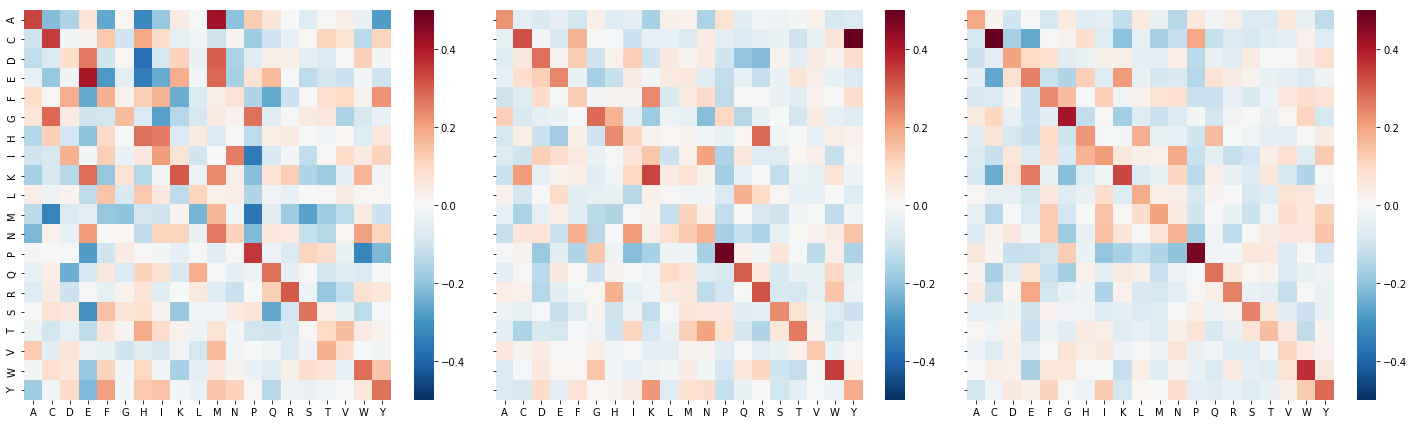

In [24]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=len(dfJk), sharex=True, sharey=True)
for i, dfJ in enumerate(dfJk):
    sns.heatmap(dfJ, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=axes[i])
fig.tight_layout()

In [27]:
k = 5
#kmers = list(itertools.product(aminoacids, repeat=k))
df = counter_to_df(count_kmers_proteome(human, k))
df = df[~df['seq'].str.contains('U|B|X|Z')]
df = df.set_index('seq')
kmers = df.index
exp = np.array([float(df.loc[''.join(s)]) for s in kmers])
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=k)]))
ising = np.exp([-energy_ising(s, h, Jk) for s in kmers])/Z
tri = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
mc = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
ind = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
rising = np.corrcoef(ising, exp)[1, 0]
rind = np.corrcoef(ind, exp)[1, 0]
rtri = np.corrcoef(tri, exp)[1, 0]
rtri, rising, np.corrcoef(mc, exp)[1, 0], rind

(0.6698462989385501, 0.658764374383573, 0.5852676481182697, 0.5268749495340342)

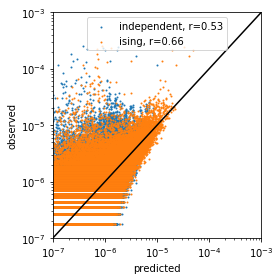

In [28]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1, label='independent, r=%1.2f'%rind)
#plt.scatter(mc, exp, s=1)
plt.scatter(ising, exp, s=1, label='ising, r=%1.2f'%rising)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.legend()
plt.xscale('log')
plt.yscale('log')
fig.tight_layout()
#fig.savefig('plots/modelfits-4mer-ising.png', dpi=300)

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1, label='independent, r=%1.2f'%rind)
#plt.scatter(mc, exp, s=1)
plt.scatter(tri, exp, s=1, label='tri, r=%1.2f'%rtri)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.legend()
plt.xscale('log')
plt.yscale('log')
fig.tight_layout()
fig.savefig('plots/modelfits-4mer-tri.png', dpi=300)

In [ ]:
pd.DataFrame(index=[key for key in h], data=[h[key] for key in h], columns=['h'])

In [ ]:
itertools.repeat?

In [ ]:
doublets = [''.join(s) for s in itertools.product(list(aminoacids), repeat=2)]

In [ ]:
df = pd.DataFrame(index=doublets, data=[Jk[0][s[0]][s[1]] for s in doublets], columns=['J0'])
for i in range(1, len(Jk)):
    df['J%g'%i] = [Jk[i][s[0]][s[1]] for s in doublets]

In [ ]:
from functools import reduce

In [ ]:
df

In [ ]:
reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), [pd.DataFrame.from_dict(
    {i+j: Jk[gap][i][j] for i in Jk[gap].keys() for j in Jk[gap][i].keys()},
    orient='index')
           for gap in range(len(Jk))])

In [ ]:
pd.merge?